# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import HTfunctions as ht
import itertools
import scipy.stats as stats
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
import seaborn as sns
import geopandas as gpd

# Data

In [2]:
finalCatchments = ht.openDict("Data/finalSelectionList.pkl")
metadata = pd.read_csv("Data/newFinalSelection_1983_2012.csv",index_col=0)

In [3]:
# dictionary of all variable trend arrays, altitude, field significance, etc.
data = {}
variables = ["_streamflow","PROstreamflow","snowmelt_","snowmeltC","rainfall_","rainfallC","temperature"]
varNames = ["Q","Qpro","SM","SMC","RF","RFC","T"]
regions = ["ost","vest"]
period = "1983_2012"
# sub-dictionaries containing each region
for region in regions:
    data[region] = {}
    # catchment numbers
    data[region]["catchmentIDs"] = finalCatchments[region]["-".join(period.split("_"))]
    
    # altitudes
    altitudes = []
    for c in data[region]["catchmentIDs"]:
        mask = metadata.snumber==c
        altitudes.append(int(metadata.altitude[mask]))
    data[region]["altitudes"] = altitudes
    
    # variables
    for i,var in enumerate(variables):
        data[region][varNames[i]] = {}
        
        # trend magnitudes
        files = ht.findFiles(f"*Mag*{var}*{region}*{period}*","Results/Daily")
        if len(files)>1:
            raise Exception(f"More than one file match the search criteria.\n{files}")
        else:
            file = files[0]
            #print(file)
            data[region][varNames[i]]["Mag"] = np.load(file)
        
        # trend significance
        files = ht.findFiles(f"*Sig*{var}*{region}*{period}*","Results/Daily")
        if var=="PROstreamflow":
            files = ht.findFiles(f"*Sig*_streamflow*{region}*{period}*","Results/Daily")
        if len(files)>1:
            raise Exception(f"More than one file match the search criteria.\n{files}")
        else:
            # there is no separate significance array for PROstreamflow
            file = files[0]
            #print(file)
            data[region][varNames[i]]["Sig"] = np.load(file)
        
        # field significance
        files = ht.findFiles(f"*{var}*{region}*{period}.csv","Results/FS")
        if var=="PROstreamflow":
            files = ht.findFiles(f"*_streamflow*{region}*{period}.csv","Results/FS")
        if len(files)>1:
            raise Exception(f"More than one file match the search criteria.\n{files}")
        else:
            file = files[0]
            #print(file)
            data[region][varNames[i]]["FieldSig"] = np.array(pd.read_csv(file).fieldSignificant)
        
        data[region][varNames[i]]["name"] = "_".join(file.split(".")[0].split("_")[1:])
        
        # "annual" trend
        if var == "temperature":
            data[region][varNames[i]]["annual"] = data[region][varNames[i]]["Mag"].mean(axis=1)
        elif var == "PROstreamflow":
            files = ht.findFiles(f"*_stream*{region}*.npy","Results/dailyMeans")
            if len(files)>1:
                raise Exception(f"More than one file match the search criteria.\n{files}")
            else:
                ann = np.load(files[0]).sum(axis=0)
                data[region][varNames[i]]["annual"] = (data[region]["Q"]["annual"]/ann)*100
        else:
            data[region][varNames[i]]["annual"] = data[region][varNames[i]]["Mag"].sum(axis=1)

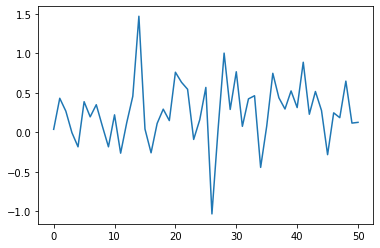

In [4]:
region = "ost"
files = ht.findFiles(f"*_stream*{region}*.npy","Results/dailyMeans")
arr = np.load(files[0])
ann = arr.sum(axis=0)
plt.plot((data["ost"]["Q"]["annual"]/ann)*100)


# Plotting

## Annual aggregated trends with altitude

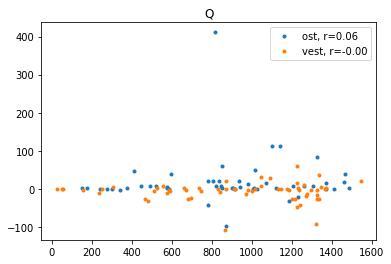

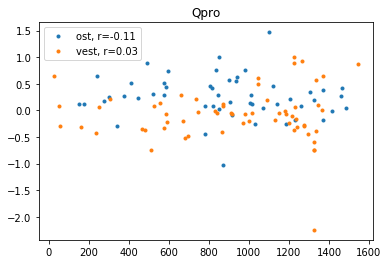

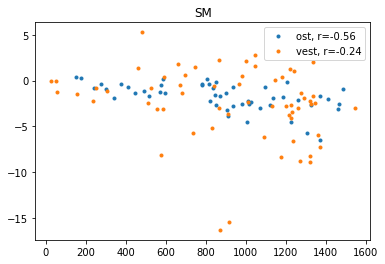

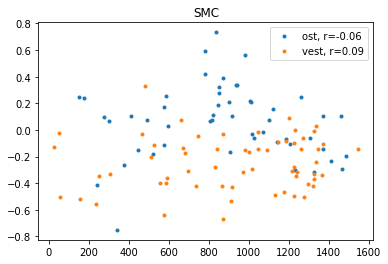

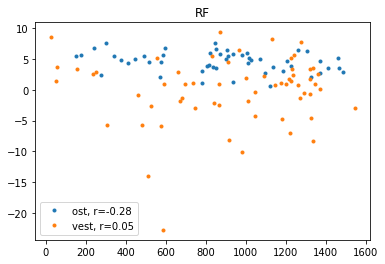

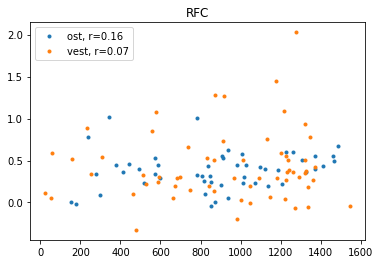

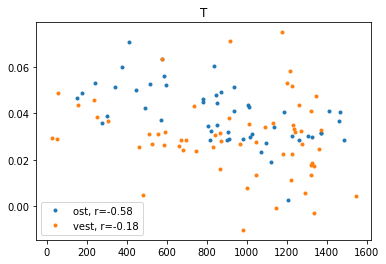

In [249]:
for var in varNames:
    plt.figure()
    for region in regions:
        r = stats.pearsonr(data[region]["altitudes"],data[region][var]["annual"])
        plt.plot(data[region]["altitudes"],data[region][var]["annual"],".",label=f"{region}, r={r[0]:.2f}")
        plt.title(f"{var}")
        plt.legend()

## Daily trends

### Field significant warming

In [139]:
def consecutive(data, stepsize=1):
    """
    This function has been modified after:
    https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-from-an-array-in-numpy
    by
    unutbu
    https://stackoverflow.com/users/190597/unutbu
    """
    return np.split(data, np.where(np.diff(i)>stepsize)[0]+1)

In [143]:
def warmingFSperiods(region):
    print(f"In region {region.upper()}\n")
    FS = data[region]["T"]["FieldSig"]
    T = data[region]["T"]["Mag"]*10
    i = np.where(FS)[0]
    print(f"The Ttrend magnitude in all field significant periods was")
    print(f"Mean = {np.round(T[:,i].mean(),2)}")
    print(f"Min = {np.round(T[:,i].min(),2)}")
    print(f"Max = {np.round(T[:,i].max(),2)}")
    print(f"Sd = {np.round(T[:,i].std(),2)}")
    print()

    stepsize=30
    FSPeriods = consecutive(i,stepsize)

    for p in FSPeriods:
        print(f"from doy {p[0]+1} to {p[-1]+1}")
        print(f"Mean = {np.round(T[:,p].mean(),2)}")
        print(f"Min = {np.round(T[:,p].min(),2)}")
        print(f"Max = {np.round(T[:,p].max(),2)}")
        print(f"Sd = {np.round(T[:,p].std(),2)}")
        print()
    print()

In [144]:
warmingFSperiods("ost")
warmingFSperiods("vest")

In region OST

The Ttrend magnitude in all field significant periods was
Mean = 0.97
Min = 0.27
Max = 2.45
Sd = 0.28

from doy 87 to 180
Mean = 1.08
Min = 0.34
Max = 1.61
Sd = 0.2

from doy 181 to 330
Mean = 0.92
Min = 0.27
Max = 2.45
Sd = 0.3


In region VEST

The Ttrend magnitude in all field significant periods was
Mean = 0.82
Min = -0.01
Max = 1.89
Sd = 0.24

from doy 87 to 120
Mean = 0.82
Min = -0.01
Max = 1.61
Sd = 0.24

from doy 179 to 275
Mean = 0.82
Min = 0.16
Max = 1.89
Sd = 0.24




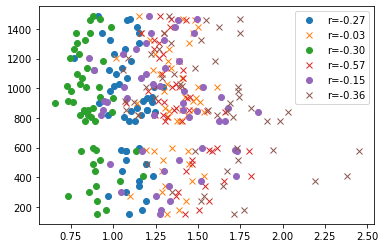

In [165]:
region = "ost"
FS = data[region]["T"]["FieldSig"]
T = data[region]["T"]["Mag"]*10
i = np.where(FS)[0]
for p in consecutive(i,30):
    mx = T[:,p].max(axis=1)
    mn = T[:,p].mean(axis=1)
    r = stats.pearsonr(mn,data[region]["altitudes"])
    plt.plot(mn,data[region]["altitudes"],"o",label=f"r={r[0]:.2f}")
    r = stats.pearsonr(mx,data[region]["altitudes"])
    plt.plot(mx,data[region]["altitudes"],"x",label=f"r={r[0]:.2f}")
plt.legend()

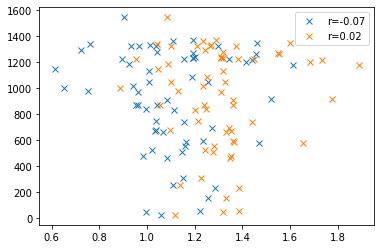

In [162]:
region = "vest"
FS = data[region]["T"]["FieldSig"]
T = data[region]["T"]["Mag"]*10
i = np.where(FS)[0]
for p in consecutive(i,30):
    mag = T[:,p].max(axis=1)
    r = stats.pearsonr(mag,data[region]["altitudes"])
    plt.plot(mag,data[region]["altitudes"],"x",label=f"r={r[0]:.2f}")
plt.legend()

### Single plots

#### Testing

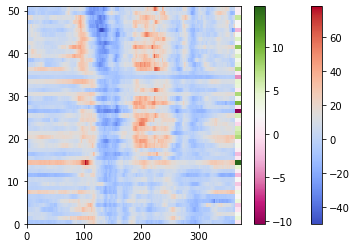

In [348]:
region = "ost"
var = "Qpro"
# magnitudes
arr = data[region][var]["Mag"]*factor
ann = (np.array([data[region][var]["annual"],]*10).T)*factor

cax = plt.pcolormesh(arr,cmap="coolwarm")
plt.colorbar(cax)
cmap = plt.cm.get_cmap("PiYG")
cax = plt.pcolormesh(np.arange(arr.shape[1],arr.shape[1]+ann.shape[1]),np.arange(arr.shape[0]+1),ann,cmap=cmap)
plt.colorbar(cax)

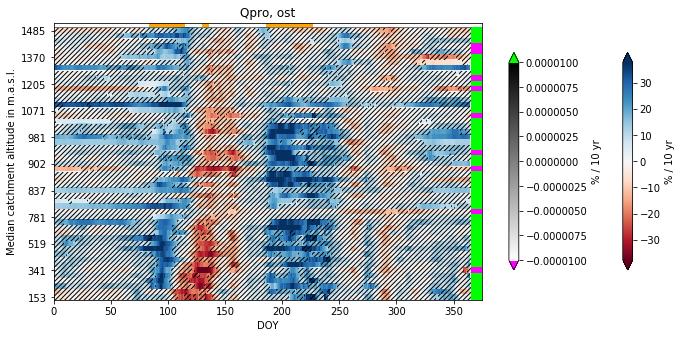

In [356]:
region = "ost"
var = "Qpro"
# magnitudes
arr = data[region][var]["Mag"]*factor
extent = max([np.abs(np.nanmax(arr,axis=1).mean()),np.abs(np.nanmin(arr,axis=1).mean())])
plt.figure(figsize=(12,arr.shape[0]/10))
cmap = cmaps[var]


#plt.imshow(arr,vmin=-extent,vmax=extent,cmap=cmap,**magArgs)
plt.pcolormesh(arrA,vmin=-extent,vmax=extent,cmap=cmap)

# colorbar
unit = f"{units[var]} / {factor} yr"
plt.colorbar(shrink=40/arr.shape[0],extend="both",label=unit)

# annual
ann = (np.array([data[region][var]["annual"],]*8).T)*factor
x = np.arange(arr.shape[1]+1,arr.shape[1]+ann.shape[1]+1)
y = np.arange(arr.shape[0]+1)
cmapAnn = plt.cm.get_cmap("binary")
cmapAnn.set_under("magenta")
cmapAnn.set_over("lime")
plt.pcolormesh(x,y,ann,vmin=-1/10**5,vmax=1/10**5,cmap=cmapAnn)

# significance
if var=="Qpro":
    sig = data[region]["Q"]["Sig"]
else:
    sig = data[region][var]["Sig"]

mask = np.ma.masked_array(np.full_like(sig,-9999),sig == 1)
#plt.imshow(mask,**sigArgs)
#plt.contourf(mask, 1, hatches=['//////'], colors="grey", alpha=0.1)
plt.pcolor(mask, hatch='/////', alpha=0.,snap=True,label="Non-significant")

# field significance
plt.hlines(-0.1,0,365,colors="k",linewidth=0.5)
field = data[region][var]["FieldSig"]
x = np.arange(365).astype(float)
y = np.full_like(x,-0.5)
np.place(x,field==False,np.nan)
np.place(y,field==False,np.nan)
plt.plot(x,y,"-",color="orange",linewidth=4)

# labels etc
plt.title(f"{var}, {region}")
plt.xlabel("DOY")
plt.ylabel("Median catchment altitude in m.a.s.l.")
ticks = np.arange(0,arr.shape[0],5)
plt.yticks(ticks+0.5,np.array(data[region]["altitudes"])[ticks])
plt.ylim(arr.shape[0],-1)
#plt.xlim(0,arr.shape[1]+0.5)


# save figure
name = data[region][var]['name']
plt.savefig(f"Plots/{period}/dailyTrend_testing.png",dpi=300,bbox_inches="tight")

In [14]:
magArgs = {"aspect":5}
sigArgs = {"alpha":0.5,
           "aspect":5,
           "cmap":"binary"}
units = {"Q":"$m^3 s^{-1}$",
         "Qpro":"%",
         "SM":"mm",
         "SMC":"%",
         "RF":"mm",
         "RFC":"%",
         "T":"$\degree C$"}
cmaps = {"Q":"RdBu",
         "Qpro":"RdBu",
         "SM":"RdBu",
         "SMC":"BrBG",
         "RF":"RdBu",
         "RFC":"BrBG",
         "T":"coolwarm"}
factor = 10 # if factor=10, it will display the trends in magnitude per decade

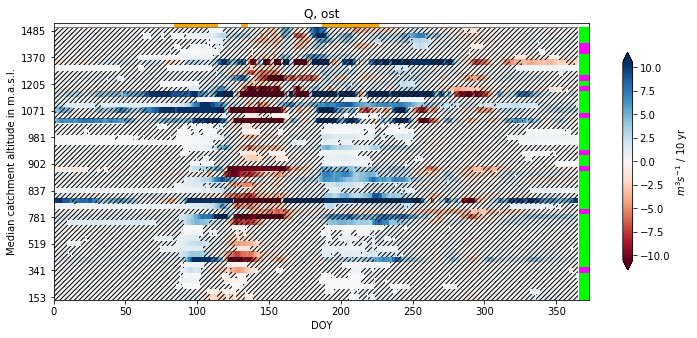

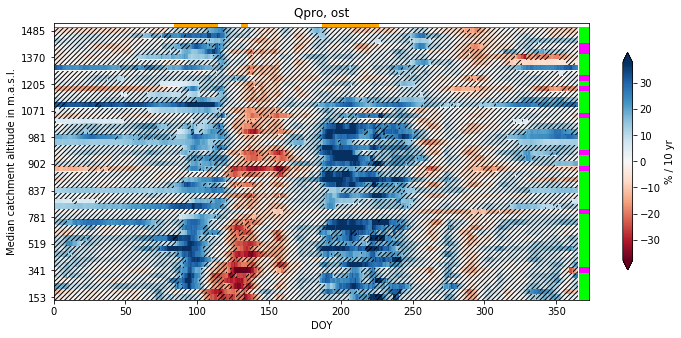

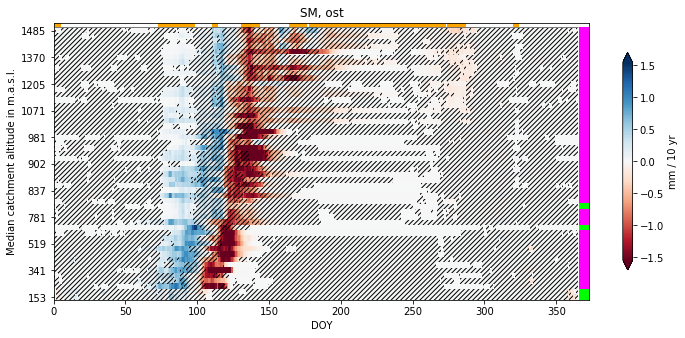

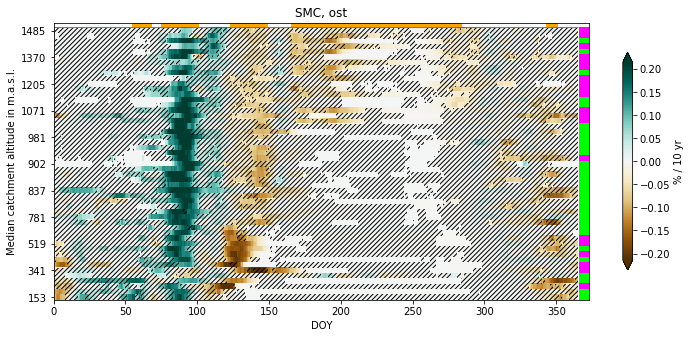

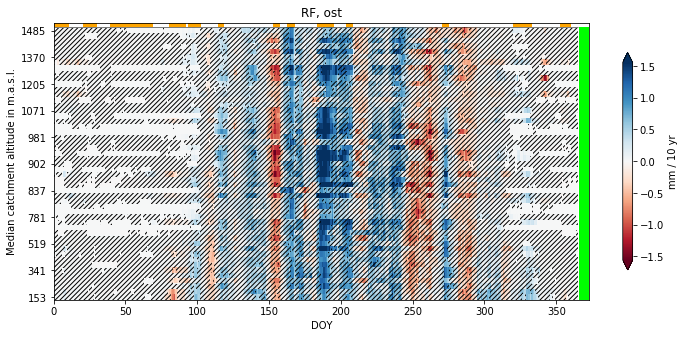

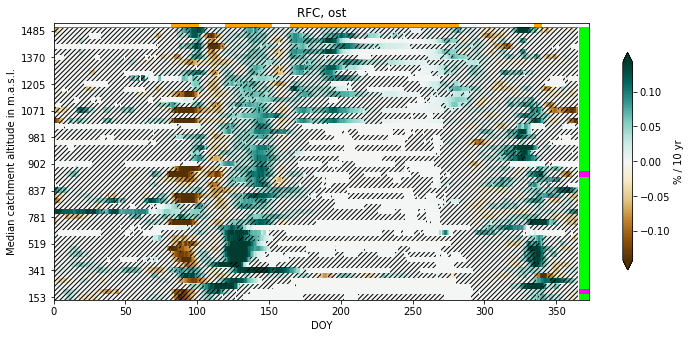

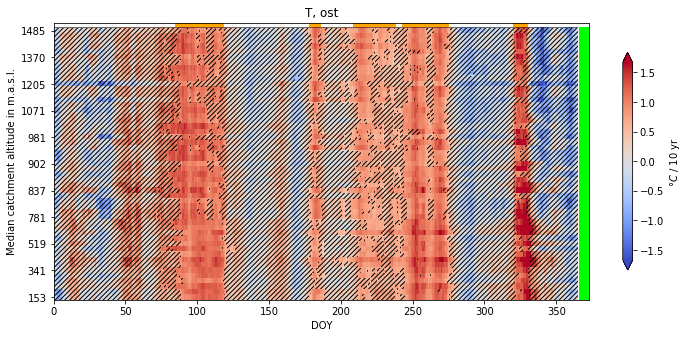

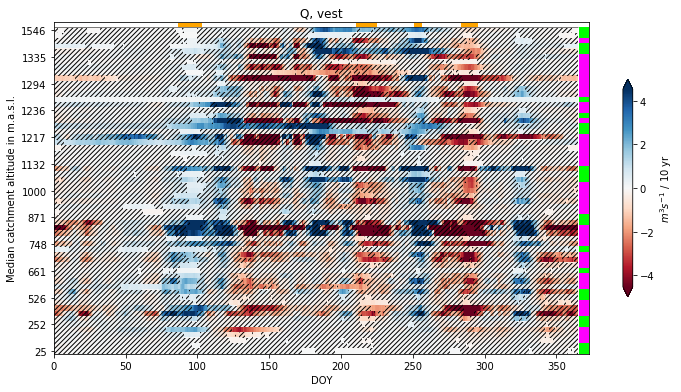

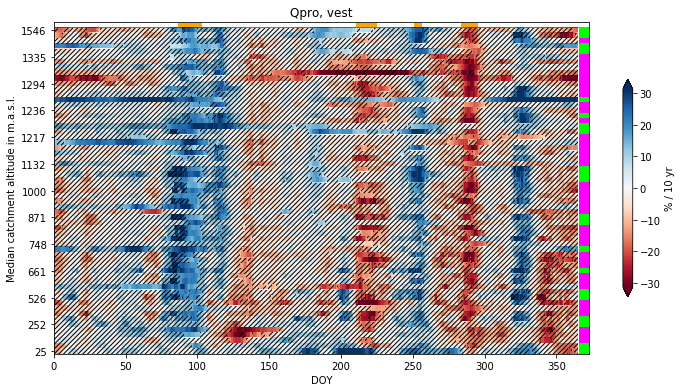

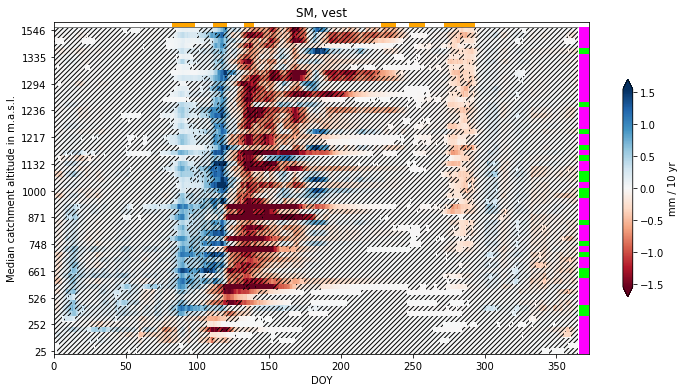

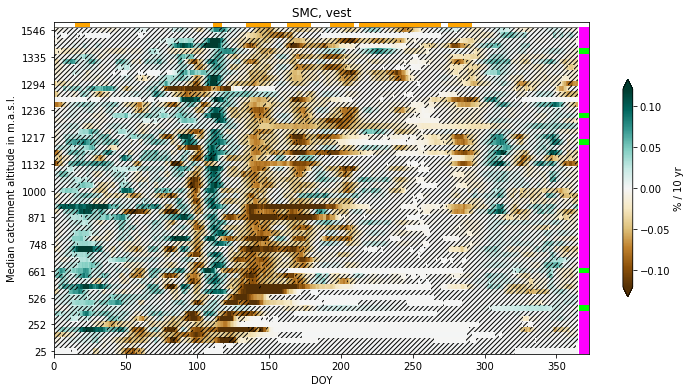

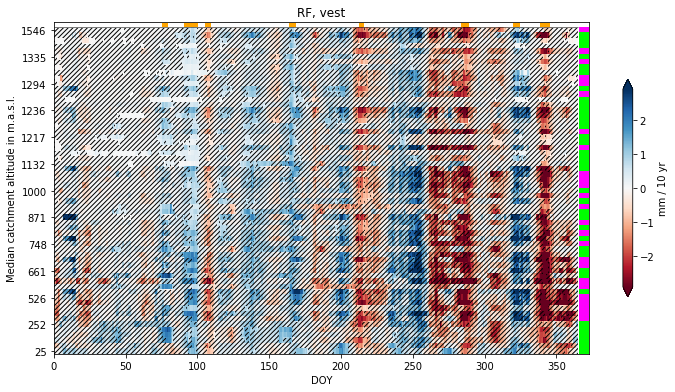

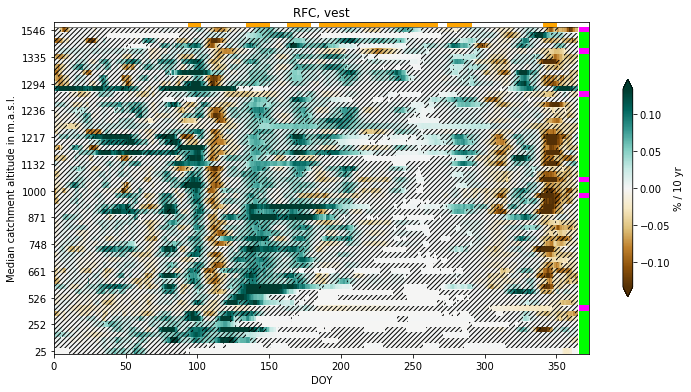

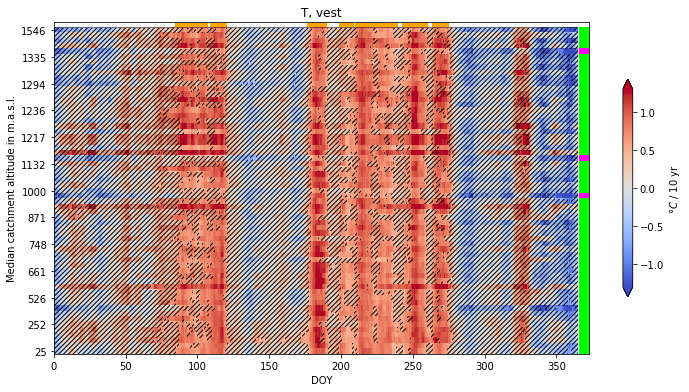

In [363]:
for region in regions:
    for var in varNames:
        # magnitudes
        arr = data[region][var]["Mag"]*factor
        extent = max([np.abs(np.nanmax(arr,axis=1).mean()),np.abs(np.nanmin(arr,axis=1).mean())])
        plt.figure(figsize=(12,arr.shape[0]/10))
        cmap = cmaps[var]


        #plt.imshow(arr,vmin=-extent,vmax=extent,cmap=cmap,**magArgs)
        plt.pcolormesh(arr,vmin=-extent,vmax=extent,cmap=cmap)

        # colorbar
        unit = f"{units[var]} / {factor} yr"
        plt.colorbar(shrink=40/arr.shape[0],extend="both",label=unit)

        # annual
        ann = (np.array([data[region][var]["annual"],]*8).T)*factor
        x = np.arange(arr.shape[1]+1,arr.shape[1]+ann.shape[1]+1)
        y = np.arange(arr.shape[0]+1)
        cmapAnn = plt.cm.get_cmap("binary")
        cmapAnn.set_under("magenta")
        cmapAnn.set_over("lime")
        plt.pcolormesh(x,y,ann,vmin=-1/10**5,vmax=1/10**5,cmap=cmapAnn)

        # significance
        if var=="Qpro":
            sig = data[region]["Q"]["Sig"]
        else:
            sig = data[region][var]["Sig"]

        mask = np.ma.masked_array(np.full_like(sig,-9999),sig == 1)
        #plt.imshow(mask,**sigArgs)
        #plt.contourf(mask, 1, hatches=['//////'], colors="grey", alpha=0.1)
        plt.pcolor(mask, hatch='/////', alpha=0.,snap=True,label="Non-significant")

        # field significance
        plt.hlines(-0.1,0,365,colors="k",linewidth=0.5)
        field = data[region][var]["FieldSig"]
        x = np.arange(365).astype(float)
        y = np.full_like(x,-0.5)
        np.place(x,field==False,np.nan)
        np.place(y,field==False,np.nan)
        plt.plot(x,y,"-",color="orange",linewidth=4)

        # labels etc
        plt.title(f"{var}, {region}")
        plt.xlabel("DOY")
        plt.ylabel("Median catchment altitude in m.a.s.l.")
        ticks = np.arange(0,arr.shape[0],5)
        plt.yticks(ticks+0.5,np.array(data[region]["altitudes"])[ticks])
        plt.ylim(arr.shape[0],-1)
        #plt.xlim(0,arr.shape[1]+0.5)

        # save figure
        name = data[region][var]['name']
        plt.savefig(f"Plots/{period}/dailyTrend_{name}.png",dpi=500,bbox_inches="tight")

### Panel plots

In [366]:
def plotDailyTrends(ax,region,var,title,aspect=5,masking="hatch"):
    magArgs = {"aspect":aspect}
    sigArgs = {"alpha":0.3,
               "aspect":aspect,
               "cmap":"binary_r"}
    units = {"Q":"$m^3 s^{-1}$",
             "Qpro":"%",
             "SM":"mm",
             "SMC":"%",
             "RF":"mm",
             "RFC":"%",
             "T":"$\degree C$"}
    cmaps = {"Q":"RdBu",
             "Qpro":"RdBu",
             "SM":"RdBu",
             "SMC":"BrBG",
             "RF":"RdBu",
             "RFC":"BrBG",
             "T":"RdBu_r"}

    factor = 10 # if factor=10, it will display the trends in magnitude per decade



    # significance array
    if var=="Qpro":
        sig = data[region]["Q"]["Sig"]
    else:
        sig = data[region][var]["Sig"]
    mask = np.ma.masked_array(np.full_like(sig,-9999),sig)
    
    # magnitudes
    arr = data[region][var]["Mag"]*factor
    extent = max([np.abs(np.nanmax(arr,axis=1).mean()),np.abs(np.nanmin(arr,axis=1).mean())])
    cmap = cmaps[var]
    
    # plotting
    if masking=="hatch":
        cax = ax.pcolormesh(arr,vmin=-extent,vmax=extent,cmap=cmap)
        ax.pcolor(mask, hatch='/////', alpha=0.,snap=True)
    else:
        cax = ax.imshow(arr,vmin=-extent,vmax=extent,cmap=cmap,**magArgs)
        ax.imshow(mask,**sigArgs)
    
    # annual
    ann = (np.array([data[region][var]["annual"],]*8).T)*factor
    x = np.arange(arr.shape[1]+1,arr.shape[1]+ann.shape[1]+1)
    y = np.arange(arr.shape[0]+1)
    cmapAnn = plt.cm.get_cmap("binary")
    cmapAnn.set_under("magenta")
    cmapAnn.set_over("lime")
    ax.pcolormesh(x,y,ann,vmin=-1/10**5,vmax=1/10**5,cmap=cmapAnn)
    
    # colorbar
    unit = f"{units[var]} / {factor} yr"
    cbar = fig.colorbar(cax,ax=ax,shrink=0.8,extend="both")
    cbar.set_label(label=unit,weight="bold")
    
    # field significance
    field = data[region][var]["FieldSig"]
    x = np.arange(365).astype(float)
    y = np.full_like(x,-0.5)
    np.place(x,field==False,np.nan)
    np.place(y,field==False,np.nan)
    ax.plot(x,y,"-",color="orange",linewidth=4)
    ax.hlines(0,0,365,colors="k",linewidth=0.5)
    ax.vlines(365,0,arr.shape[0],colors="k",linewidth=0.5)

    # labels etc
    ax.set_title(title,fontsize=14,weight="bold",loc="left")
    ax.set_xlabel("DOY")
    ax.set_ylabel("Median catchment altitude in m.a.s.l.")
    ticks = np.arange(0,arr.shape[0],5)
    ax.set_yticks(ticks+0.5) 
    ax.set_yticklabels(np.array(data[region]["altitudes"])[ticks])
    ax.set_ylim(arr.shape[0],-1)
    #ax.set_xlim(0,arr.shape[1]+0.5)

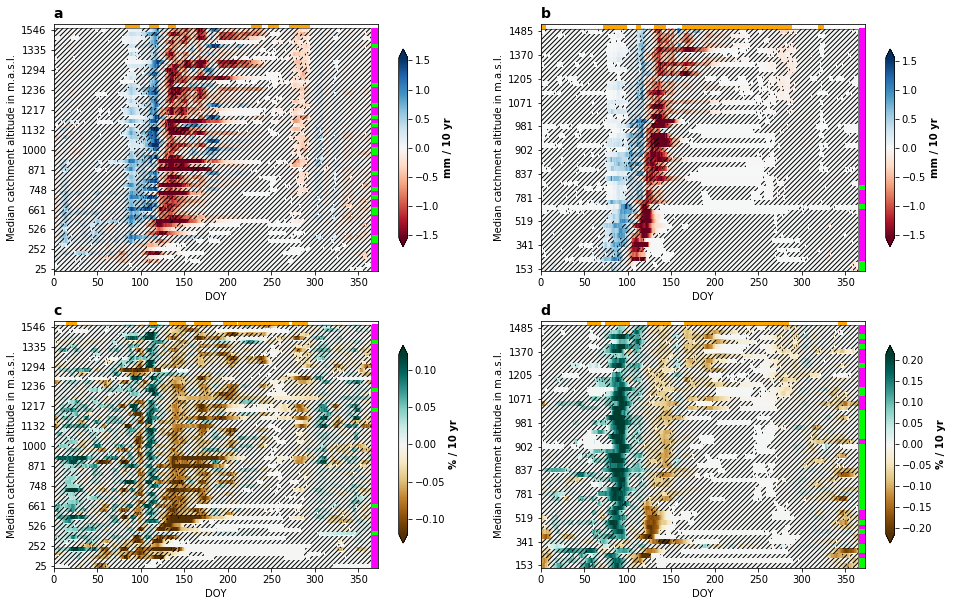

In [367]:
fig = plt.figure(figsize=(16,10))
gs = GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

plotDailyTrends(ax1,"vest","SM","a",aspect=4.2)
plotDailyTrends(ax2,"ost","SM","b")
plotDailyTrends(ax3,"vest","SMC","c",aspect=4.2)
plotDailyTrends(ax4,"ost","SMC","d")

plt.savefig("Paper and poster/snowmeltTrends.png",dpi=600,bbox_inches='tight')

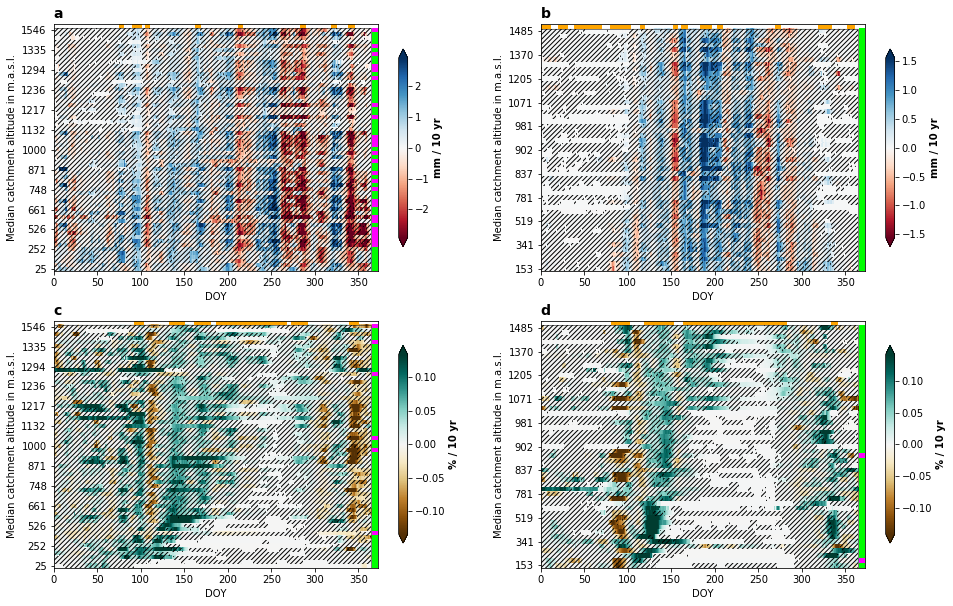

In [361]:
fig = plt.figure(figsize=(16,10))
gs = GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

plotDailyTrends(ax1,"vest","RF","a",aspect=4.2)
plotDailyTrends(ax2,"ost","RF","b")
plotDailyTrends(ax3,"vest","RFC","c",aspect=4.2)
plotDailyTrends(ax4,"ost","RFC","d")

plt.savefig("Paper and poster/rainfallTrends.png",dpi=600,bbox_inches='tight')

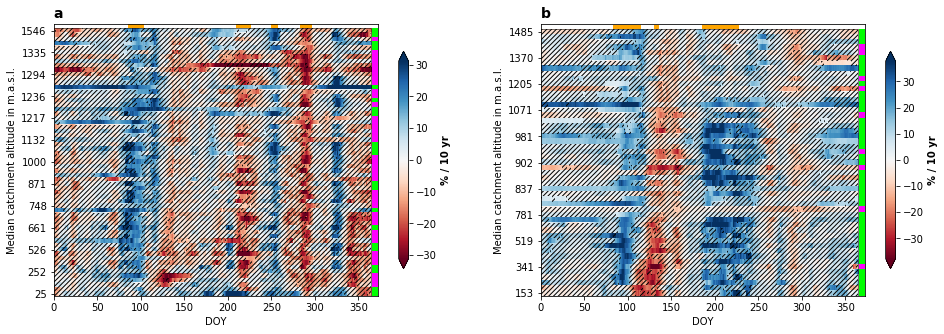

In [362]:
fig = plt.figure(figsize=(16,5))
gs = GridSpec(1, 2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plotDailyTrends(ax1,"vest","Qpro","a",aspect=4.2)
plotDailyTrends(ax2,"ost","Qpro","b")

plt.savefig("Paper and poster/streamflowTrends.png",dpi=600,bbox_inches='tight')

## Attribution

In [5]:
# Q ~ SM + RF
ost = pd.read_csv("Results/OLS/multiregression_QSMRF_ost_1983_2012_annual.csv")
vest = pd.read_csv("Results/OLS/multiregression_QSMRF_vest_1983_2012_annual.csv")


# Q ~ SM + RF + T
ost3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_ost_1983_2012_annual.csv")
vest3 = pd.read_csv("Results/OLS/multiregression_QSMRFT_vest_1983_2012_annual.csv")

In [6]:
regions = ["ost","vest"]
models = ["QSMRFT","QSMRF","QSM","QRF","QT"]
seasons = ["annual","winter","spring","summer","autumn"]
attribution = {}
for region in regions:
    attribution[region] = {}
    for model in models:
        attribution[region][model] = {}
        for season in seasons:
            files = ht.findFiles(f"*{model}_*{region}*{season}*.csv","Results/OLS")
            for file in files:
                attribution[region][model][season] = pd.read_csv(file)

In [7]:
attr_labels = {"QSMRFT":"$Q_{trend} \sim SM_{trend} + RF_{trend} + T_{trend}$\n",
               "QSMRF":"$Q_{trend} \sim SM_{trend} + RF_{trend}$\n",
               "QSM":"$Q_{trend} \sim SM_{trend}$\n",
               "QRF":"$Q_{trend} \sim RF_{trend}$\n",
               "QT":"$Q_{trend} \sim T_{trend}$\n"}

### Overview table

In [64]:
overview = {}
for region in regions:
    overview[region]={}
    for season in seasons:
        table={}
        for model in models:
            res = attribution[region][model][season]
            table[model] = {}
            a = np.arange(0,1,0.2)

            for i in range(len(a)):
                lower = np.round(a[i],1)
                upper = np.round(lower+0.2,1)
                mask = (upper>=res.rsquared_adj)&(res.rsquared_adj>lower)
                table[model][f"{lower}-{upper}"] = mask.sum()
            
        overview[region][season]=pd.DataFrame(table).T
        
overview["all"] = {}
for season in seasons:
    overview["all"][season] = overview["vest"][season]+overview["ost"][season]

In [86]:
for k in list(overview.keys()):
    print(overview[k]["annual"])

        0.0-0.2  0.2-0.4  0.4-0.6  0.6-0.8  0.8-1.0
QSMRFT        8       18       12       12        1
QSMRF        10       18       10       12        1
QSM          18       18       10        4        0
QRF          41        4        1        0        0
QT           47        1        0        0        0
        0.0-0.2  0.2-0.4  0.4-0.6  0.6-0.8  0.8-1.0
QSMRFT        4       21       23       13        0
QSMRF        14       18       17       12        0
QSM          32       21        3        1        0
QRF          30       19       10        1        0
QT           47        8        1        0        0
        0.0-0.2  0.2-0.4  0.4-0.6  0.6-0.8  0.8-1.0
QSMRFT       12       39       35       25        1
QSMRF        24       36       27       24        1
QSM          50       39       13        5        0
QRF          71       23       11        1        0
QT           94        9        1        0        0


In [135]:
season = "annual"

newTable = {}
for model in models:
    newTable[model] = {}
    
    a = overview["all"][season]
    v = overview["vest"][season]
    o = overview["ost"][season]
    
    for q in list(overview["all"][season].columns):
        newTable[model][q] = f"{a.loc[model,q]:>2} ({v.loc[model,q]:>2};{o.loc[model,q]:>2})"

df = pd.DataFrame(newTable).T
print(df)
df.to_csv("Paper and poster/overviewAttribution.csv")

           0.0-0.2     0.2-0.4     0.4-0.6     0.6-0.8     0.8-1.0
QSMRFT  12 ( 4; 8)  39 (21;18)  35 (23;12)  25 (13;12)   1 ( 0; 1)
QSMRF   24 (14;10)  36 (18;18)  27 (17;10)  24 (12;12)   1 ( 0; 1)
QSM     50 (32;18)  39 (21;18)  13 ( 3;10)   5 ( 1; 4)   0 ( 0; 0)
QRF     71 (30;41)  23 (19; 4)  11 (10; 1)   1 ( 1; 0)   0 ( 0; 0)
QT      94 (47;47)   9 ( 8; 1)   1 ( 1; 0)   0 ( 0; 0)   0 ( 0; 0)


### Effect of including $T_{trend}$

#### $R^2$

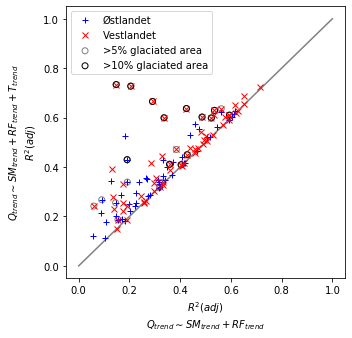

In [257]:
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],"grey")
plt.plot(ost.rsquared_adj,ost3.rsquared_adj,"+b",label="Østlandet")
plt.plot(vest.rsquared_adj,vest3.rsquared_adj,"xr",label="Vestlandet")

glimit = 5
mask = metadata.BREPRO>glimit
glaciated = list(metadata.snumber[mask])
mask = ost.snumber.isin(glaciated)
plt.scatter(ost.rsquared_adj[mask],ost3.rsquared_adj[mask],edgecolor="grey",facecolor="none",label=f">{glimit}% glaciated area")
mask = vest.snumber.isin(glaciated)
plt.scatter(vest.rsquared_adj[mask],vest3.rsquared_adj[mask],edgecolor="grey",facecolor="none")

glimit = 10
mask = metadata.BREPRO>glimit
glaciated = list(metadata.snumber[mask])
mask = ost.snumber.isin(glaciated)
plt.scatter(ost.rsquared_adj[mask],ost3.rsquared_adj[mask],edgecolor="k",facecolor="none",label=f">{glimit}% glaciated area")
mask = vest.snumber.isin(glaciated)
plt.scatter(vest.rsquared_adj[mask],vest3.rsquared_adj[mask],edgecolor="k",facecolor="none")


plt.xlabel("$R^2(adj)$ \n$Q_{trend} \sim SM_{trend} + RF_{trend}$")
plt.ylabel("$Q_{trend} \sim SM_{trend} + RF_{trend} + T_{trend}$\n$R^2(adj)$")
plt.legend()
plt.savefig("Paper and poster/QSMRFTvsQSMRF.png",dpi=600,bbox_inches='tight')

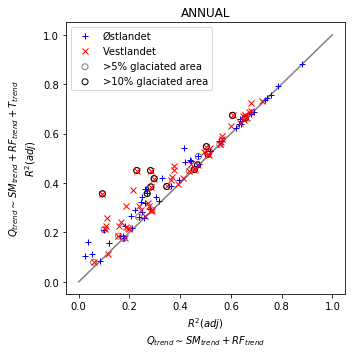

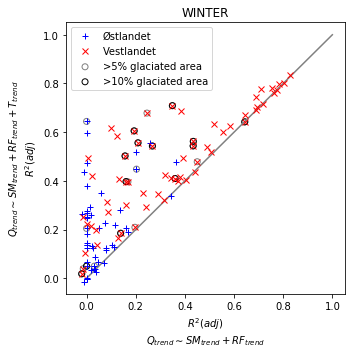

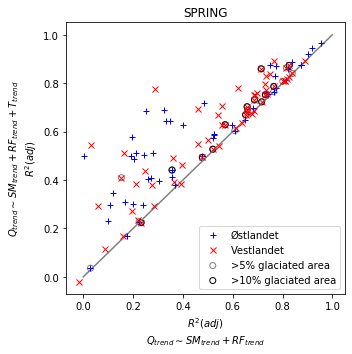

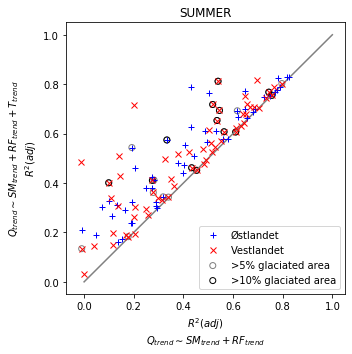

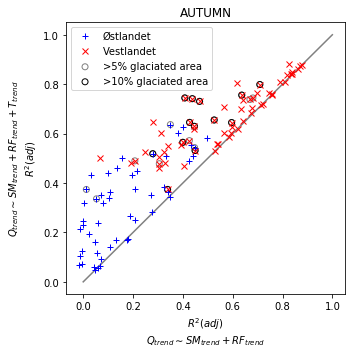

In [10]:
for season in seasons:
    ost = attribution["ost"]["QSMRF"][season]
    ost3 = attribution["ost"]["QSMRFT"][season]
    vest = attribution["vest"]["QSMRF"][season]
    vest3 = attribution["vest"]["QSMRFT"][season]

    plt.figure(figsize=(5,5))
    plt.plot([0,1],[0,1],"grey")
    plt.plot(ost.rsquared_adj,ost3.rsquared_adj,"+b",label="Østlandet")
    plt.plot(vest.rsquared_adj,vest3.rsquared_adj,"xr",label="Vestlandet")

    glimit = 5
    mask = metadata.BREPRO>glimit
    glaciated = list(metadata.snumber[mask])
    mask = ost.snumber.isin(glaciated)
    plt.scatter(ost.rsquared_adj[mask],ost3.rsquared_adj[mask],edgecolor="grey",facecolor="none",label=f">{glimit}% glaciated area")
    mask = vest.snumber.isin(glaciated)
    plt.scatter(vest.rsquared_adj[mask],vest3.rsquared_adj[mask],edgecolor="grey",facecolor="none")

    glimit = 10
    mask = metadata.BREPRO>glimit
    glaciated = list(metadata.snumber[mask])
    mask = ost.snumber.isin(glaciated)
    plt.scatter(ost.rsquared_adj[mask],ost3.rsquared_adj[mask],edgecolor="k",facecolor="none",label=f">{glimit}% glaciated area")
    mask = vest.snumber.isin(glaciated)
    plt.scatter(vest.rsquared_adj[mask],vest3.rsquared_adj[mask],edgecolor="k",facecolor="none")

    plt.title(season.upper())
    plt.xlabel("$R^2(adj)$ \n$Q_{trend} \sim SM_{trend} + RF_{trend}$")
    plt.ylabel("$Q_{trend} \sim SM_{trend} + RF_{trend} + T_{trend}$\n$R^2(adj)$")
    plt.legend()

    plt.savefig(f"Paper and poster/QSMRFTvsQSMRF_{season}.png",dpi=600,bbox_inches='tight')

#### AIC

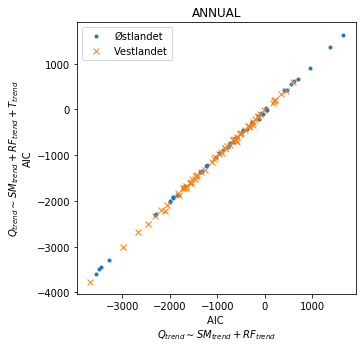

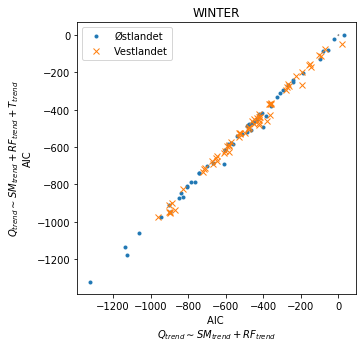

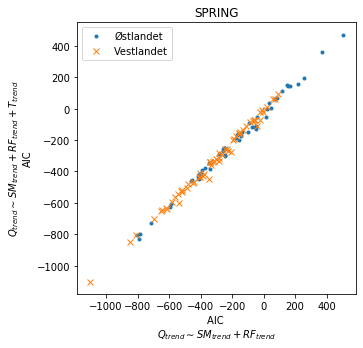

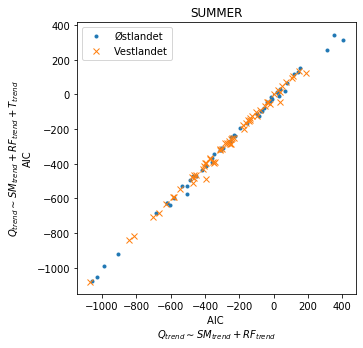

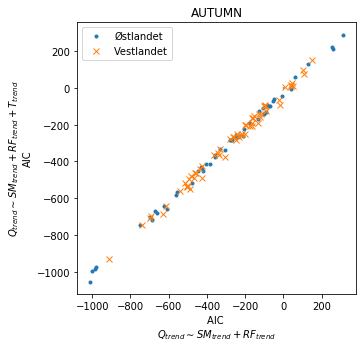

In [18]:
for season in seasons:
    ost = attribution["ost"]["QSMRF"][season]
    ost3 = attribution["ost"]["QSMRFT"][season]
    vest = attribution["vest"]["QSMRF"][season]
    vest3 = attribution["vest"]["QSMRFT"][season]

    plt.figure(figsize=(5,5))
    plt.plot([0,1],[0,1],"grey")
    plt.plot(ost.aic,ost3.aic,".",label="Østlandet")
    plt.plot(vest.aic,vest3.aic,"x",label="Vestlandet")
    plt.xlabel("AIC \n$Q_{trend} \sim SM_{trend} + RF_{trend}$")
    plt.ylabel("$Q_{trend} \sim SM_{trend} + RF_{trend} + T_{trend}$\nAIC")
    plt.legend()
    plt.title(season.upper())
    plt.savefig(f"Paper and poster/QSMRFTvsQSMRF_{season}_aic.png",dpi=600,bbox_inches='tight')

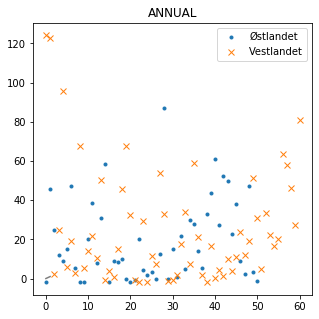

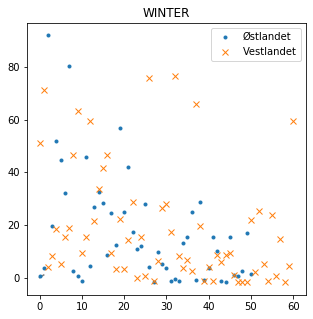

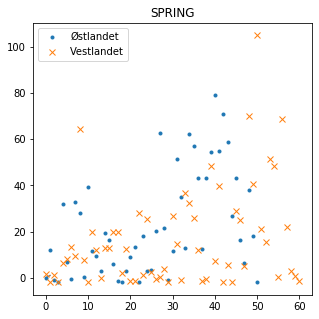

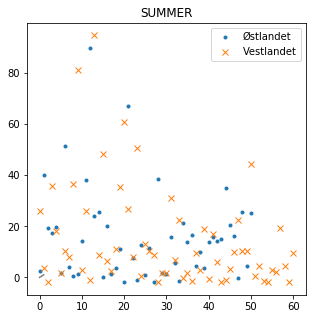

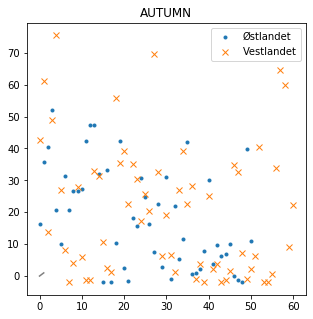

In [19]:
for season in seasons:
    ost = attribution["ost"]["QSMRF"][season]
    ost3 = attribution["ost"]["QSMRFT"][season]
    vest = attribution["vest"]["QSMRF"][season]
    vest3 = attribution["vest"]["QSMRFT"][season]

    plt.figure(figsize=(5,5))
    plt.plot([0,1],[0,1],"grey")
    plt.plot(ost.aic-ost3.aic,".",label="Østlandet")
    plt.plot(vest.aic-vest3.aic,"x",label="Vestlandet")
    plt.title(season.upper())
    plt.legend()

#### Glaciation

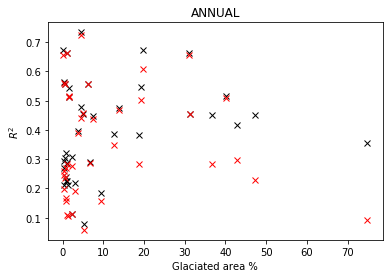

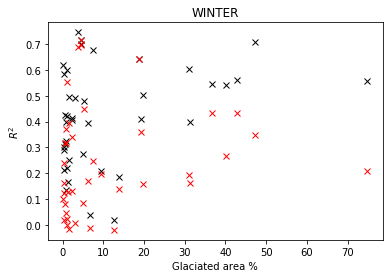

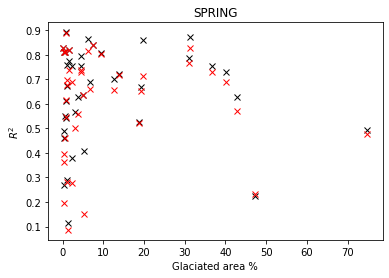

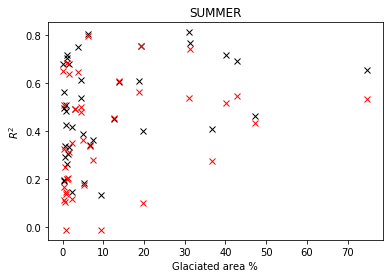

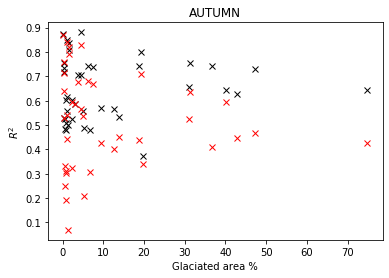

In [49]:
region = "vest"
model = "QSMRFT"
season = "annual"

for season in seasons:
    glimit = 0
    mask = metadata.BREPRO>glimit
    glaciated = list(metadata.snumber[mask])

    res = attribution[region]["QSMRFT"][season]
    mask = res.snumber.isin(glaciated)
    r2 = res[mask].rsquared_adj
    plt.figure()
    for c in res[mask].snumber:
        plt.plot(metadata[metadata.snumber==c].BREPRO,res[res.snumber==c].rsquared_adj,"xk")
    
    res = attribution[region]["QSMRF"][season]
    mask = res.snumber.isin(glaciated)
    r2 = res[mask].rsquared_adj
    #plt.figure()
    for c in res[mask].snumber:
        plt.plot(metadata[metadata.snumber==c].BREPRO,res[res.snumber==c].rsquared_adj,"xr")
    
    plt.ylabel("$R^2$")
    plt.xlabel("Glaciated area %")
    plt.title(season.upper())

#### $T_{trend}$ coefficient

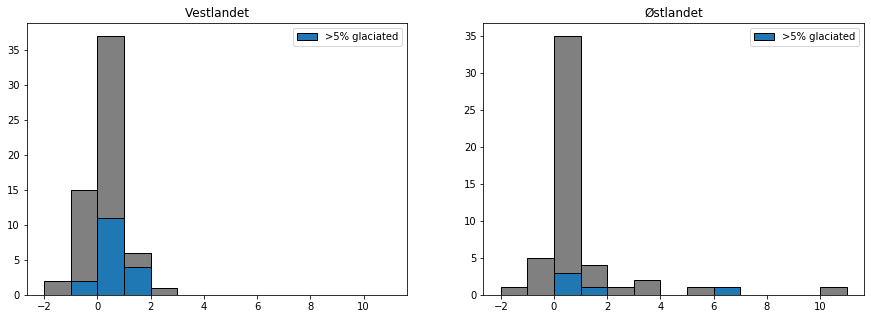

In [323]:
kwargs = {"range":(-2,11),
          "bins":13,
          "edgecolor":"k",
          "linewidth":1}

fig,ax = plt.subplots(figsize=(15,5),ncols=2,nrows=1)

glimit = 5
mask = metadata.BREPRO>glimit
glaciated = list(metadata.snumber[mask])

ax[0].hist(vest3.x3_temp,color="grey",**kwargs)
mask = vest3.snumber.isin(glaciated)
vest3.x3_temp[mask]
ax[0].hist(vest3.x3_temp[mask],**kwargs,label=f">{glimit}% glaciated")
ax[0].set_title("Vestlandet")
ax[0].legend()

#plt.figure()
ax[1].hist(ost3.x3_temp,color="grey",**kwargs)
mask = ost3.snumber.isin(glaciated)
ost3.x3_temp[mask]
ax[1].hist(ost3.x3_temp[mask],**kwargs,label=f">{glimit}% glaciated")
ax[1].set_title("Østlandet")
plt.legend()

### Maps

#### Function

In [320]:
def plotRegressionQualityLocation(reg1,reg2,subplotting=False,ax=None):
    """
    Plotting catchments colorcoded by quality of regression (R²).

    Parameters
    ----------
    reg1: pandas.DataFrame
    reg2: pandas.DataFrame
    """
    norge = gpd.read_file("Data/gis/Norge.shp")
    regionLines = gpd.read_file("Data/gis/Grense_Avrenningsregioner.shp")
    
    # quality colors to use in map
    cmap = plt.cm.get_cmap("jet_r")

    qcol = []
    for i in np.linspace(0.1,0.9,5):
        qcol.append(cmap(i))

    qlabel = ["$R^2$ < 0.2",
              "$R^2$ = 0.2-0.4",
              "$R^2$ = 0.4-0.6",
              "$R^2$ = 0.6-0.8",
              "$R^2$ > 0.8"]
    
    if subplotting:
        # plotting and saving map
        norge.plot(ax=ax,color="white", edgecolor="lightgrey")
        regionLines.plot(ax=ax,color="darksalmon",label="Runoff region border")

        for qual in np.arange(5):
            stationSel = ht.getStations(reg1,qual)
            stationSel.plot(ax=ax,marker="o",markersize=50,color=qcol[qual],label=qlabel[qual],alpha=.6)
            stationSel = ht.getStations(reg2,qual)
            stationSel.plot(ax=ax,marker="o",markersize=50,color=qcol[qual],label="",alpha=.6)

        ax.set_ylim(6450000,7100000)
        ax.set_xlim(-100000,400000)
        #ax.axis('off')
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklines(), visible=False)
        plt.setp(ax.get_yticklines(), visible=False)
        plt.setp(ax.spines.values(), visible=False)
        
    else:
        # plotting and saving map
        fig,ax = plt.subplots(figsize=(7,7))
        norge.plot(ax=ax,color="white", edgecolor="lightgrey")
        regionLines.plot(ax=ax,color="darksalmon",label="Runoff region border")

        for qual in np.arange(5):
            stationSel = getStations(reg1,qual)
            stationSel.plot(ax=ax,marker="o",markersize=60,color=qcol[qual],label=qlabel[qual],alpha=.6)
            stationSel = getStations(reg2,qual)
            stationSel.plot(ax=ax,marker="o",markersize=60,color=qcol[qual],label="",alpha=.6)

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        plt.setp(ax.get_xticklines(), visible=False)
        plt.setp(ax.get_yticklines(), visible=False)
        plt.setp(ax.spines.values(), visible=False)
        plt.ylim(6450000,7300000)
        plt.xlim(-100000,400000)
        plt.legend(loc="upper left")

#### Panelplot

/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packag

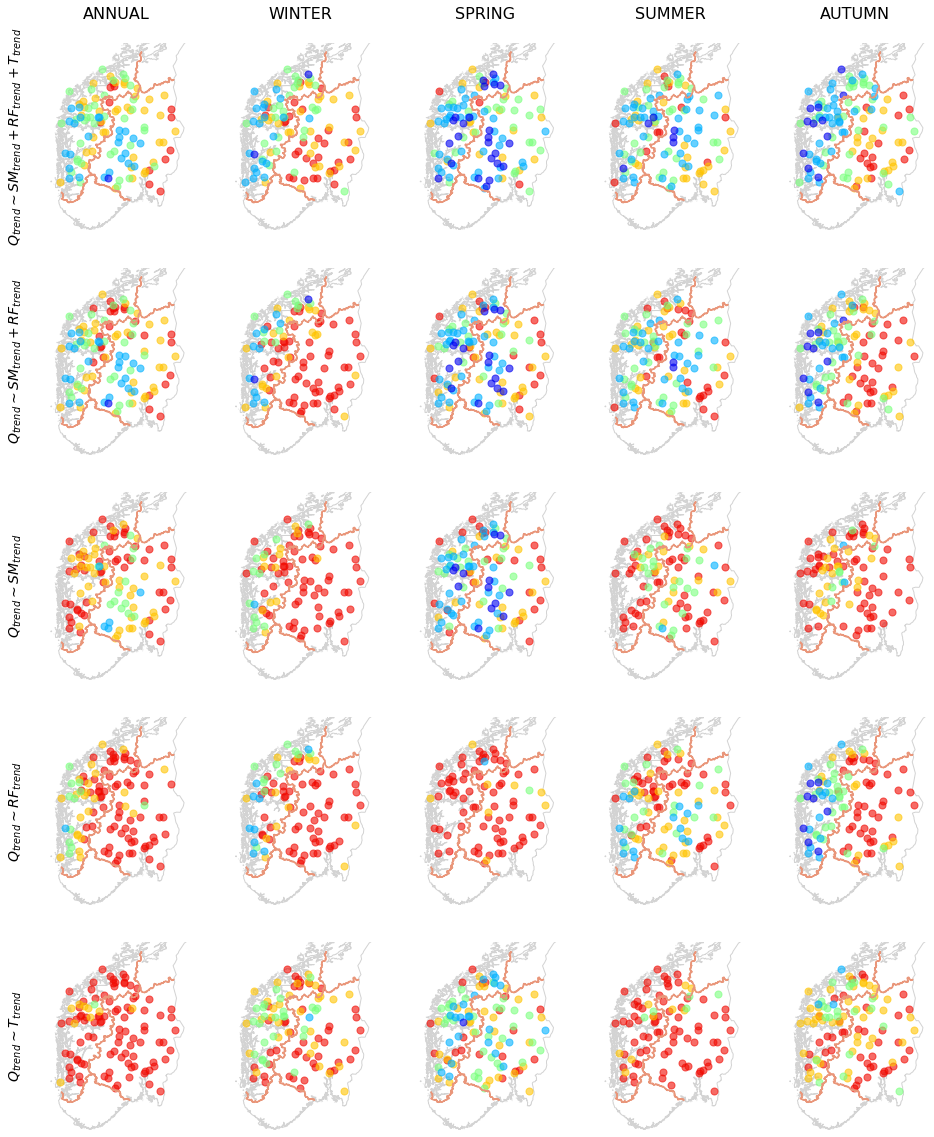

In [324]:
fig,ax = plt.subplots(nrows=5,ncols=5,figsize=(16,20))
for j,model in enumerate(models):
    for i,season in enumerate(seasons):
        reg1 = attribution["ost"][model][season]
        reg2 = attribution["vest"][model][season]
        plotRegressionQualityLocation(reg1,reg2,subplotting=True,ax=ax[j][i])
        if j==0:
            ax[j][i].set_title(f"{season.upper()}\n",fontsize=16)
        if i == 0:
            ax[j][i].set_ylabel(attr_labels[model],fontsize=14)

plt.savefig("Paper and poster/attribution.png",dpi=600,bbox_inches='tight')

#### Individual

/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/skalevag/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


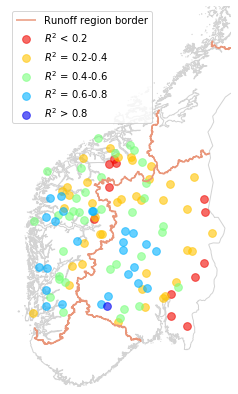

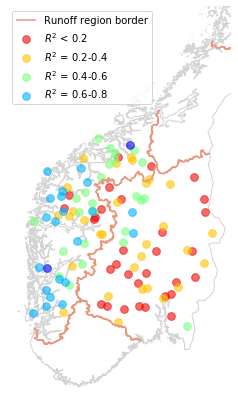

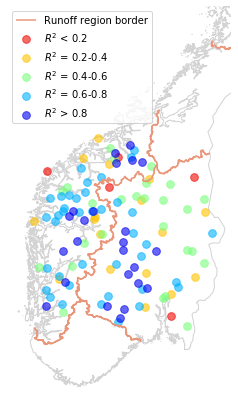

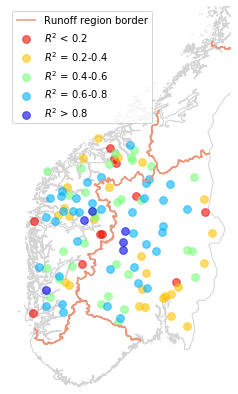

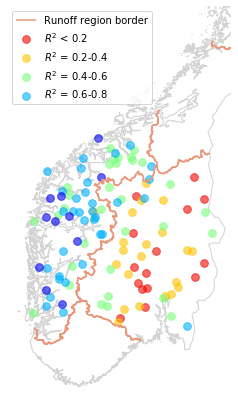

In [42]:
for season in seasons:
    reg1 = attribution["ost"]["QSMRFT"][season]
    reg2 = attribution["vest"]["QSMRFT"][season]
    ht.plotRegressionQualityLocation(reg1,reg2)

# Extra

In [12]:
metadata.columns

Index(['snumber', 'regine', 'main', 'name', 'stnr', 'start.yr', 'end.yr',
       'missing.yr', 'areal', 'altitude', 'utm.e', 'runoff.region', 'lon',
       'lat', 'AREAL_NOR', 'GRAD_FELT', 'GRAD_ELV', 'HEIGHT_MIN', 'HEIGHT_50',
       'HEIGHT_MAX', 'JORDBRUKPR', 'MYRPRO', 'SKOGPRO', 'BREPRO', 'SJOPRO',
       'SNAUFJPRO'],
      dtype='object')

In [13]:
a = vest[['snumber', 'rsquared_adj', 'intercept', 'x1_snow', 'x2_rain']]
m = metadata[['snumber', 'areal', 'altitude', 'lon',
       'lat',  'GRAD_FELT', 'HEIGHT_MIN', 
       'HEIGHT_MAX', 'JORDBRUKPR', 'MYRPRO', 'SKOGPRO', 'BREPRO', 'SJOPRO',
       'SNAUFJPRO']]
test = a.merge(m)

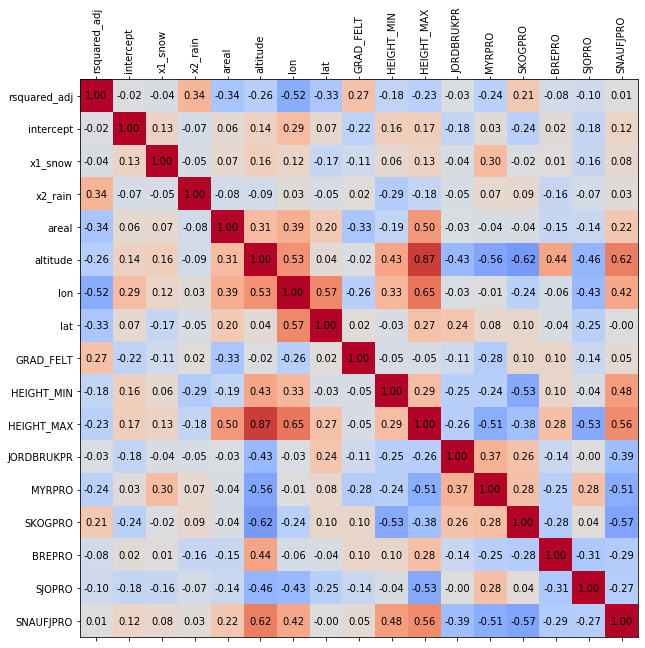

In [18]:
ht.plotCorrMatrix(test.iloc[:,1:].corr(),(10,10))